<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/Deep_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
av_vols = np.mean(train_vols[3], axis = 0)

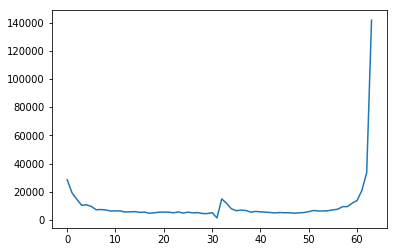

In [7]:
plt.plot(av_vols)

In [0]:
#create covariates - currently one hot vector 64 dims but experiment with different ideas 
def create_covariate_data(input_data, freq = 64): #this is assuming that data starts at beginning of day and ends at last bin of the day 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  covariate_vectors = np.zeros((num_series, len_series, freq+1))
  
  for n in range(num_series):
    for d in range(days): 
      for t in range(freq): 
        one_hot = np.zeros(freq)
        one_hot[t] = 1
        covariate_vectors[n, d*64 + t, 0] = input_data[n, d*64 + t]
        covariate_vectors[n, d*64 + t, 1:] = one_hot
        
  return covariate_vectors

In [0]:
train_volume = train_vols[0:50].reshape((50,-1))

norm_train_vols = np.zeros((50, 29568))
for i in range(50): 
  norm_train_vols[i] = train_volume[i]/np.amax(train_vols[i])
  
T = 64*3
new_train_data = norm_train_vols[:,:T]

covars_data = create_covariate_data(new_train_data)

covars_data = torch.FloatTensor(covars_data)

In [0]:
test_volume = train_vols[50:100].reshape((50,-1))

norm_test_vols = np.zeros((50, 29568))
for i in range(50): 
  norm_test_vols[i] = test_volume[i]/np.amax(train_vols[i])
  
T = 64*3
new_test_data = norm_test_vols[:,:T]

covars_test_data = create_covariate_data(new_test_data)

covars_test_data = torch.FloatTensor(covars_test_data)

In [0]:
class GlobalEffects(nn.Module): 
  def __init__(self, input_size, num_factors, hidden_size, batch_size = 1, output_size = 1, num_layers = 1): 
    super().__init__()
    self.input_size = input_size
    self.num_factors = num_factors
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.linears = nn.ModuleList([nn.Linear(self.hidden_size, self.output_size, bias = False) for i in range(self.num_factors)])
    self.lstms = nn.ModuleList([nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers) for i in range(self.num_factors)])
    
    self.w = torch.nn.Parameter(torch.zeros(batch_size, num_factors))
    
  def init_hidden(self): 
    hidden = [torch.zeros(self.num_layers, self.batch_size, self.hidden_size) for i in range(self.num_factors)]
    return hidden
    
  def forward(self, input_data, hidden): 
    x = input_data[:,1:]
    for i in range(self.num_factors): 
      lstm_out, hidden[i] = self.lstms[i](x.view(len(x), self.batch_size, -1))
      g_i = self.linears[i](lstm_out).view(-1,1)
      
      if i == 0: 
        g = g_i
      else:
        g = torch.cat((g,g_i), dim=1)

    fixed_effects = torch.zeros(g.shape[0])
    for i in range(g.shape[0]): 
      fixed_effects[i] = torch.dot(self.w.view(-1), g[i])
      
    return fixed_effects
    
    #NEED TO ADD AN ATTENTION LAYER HERE 
      

In [0]:
class DF_RNN(nn.Module): 
  def __init__(self, input_size, hidden_size, batch_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size

    self.rnn = nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = 1)
    self.linear = nn.Linear(self.hidden_size, self.output_size)
    
  def init_hidden(self): 
      return torch.zeros(1, self.batch_size, self.hidden_size)
    
  def forward(self, input_data, hidden, fixed_effects, gaussian_likelihood): 
    z = input_data[:,0]
    x = input_data[:,1:]
    rnn_out, hidden = self.rnn(x.view(len(x), self.batch_size, -1))
    sigma = self.linear(rnn_out).view(-1)
    sigma = torch.abs(sigma)
    r = torch.zeros(sigma.shape[0])
    for i in range(sigma.shape[0]):
      r[i] = torch.distributions.normal.Normal(0, sigma[i]).rsample()
    u = fixed_effects + r
    
    if gaussian_likelihood == True: 
      log_lik = self.log_likelihood_Gaussian(z, fixed_effects, sigma)
    
    else: 
      log_lik = self.log_likelihood_nonGaussian()
    
    return log_lik
   
  def log_likelihood_Gaussian(self, z, f, sigma):
    log_p = torch.zeros(len(z))
    for i in range(len(z)): 
      log_pdf = torch.distributions.normal.Normal(0, sigma[i]).log_prob(z[i] - f[i])
      #scale the likelihood to 0-1
      log_norm_constant = torch.distributions.normal.Normal(0, sigma[i]).log_prob(0)
      log_p[i] = log_pdf - log_norm_constant
      
    #set neg infinite values to -10 to avoid batch loss becoming infinite 
    log_p[log_p == -float("inf")] = -10
    
    log_lik = torch.sum(log_p)

    return log_lik
  
  
  def log_likelihood_nonGaussian(self, ): #to do 
    pass

In [0]:
learning_rate = 0.0001
batch_size = 50 #??????
num_epochs = 100
hidden_units_global = 50
hidden_units_local = 5
n_factors = 10 

In [0]:
global_model = GlobalEffects(input_size = 64, num_factors = n_factors , hidden_size = hidden_units_global)  
local_model = DF_RNN(64, hidden_size = hidden_units_local, batch_size = 1, output_size = 1)

In [108]:
optimiser = torch.optim.SGD(list(global_model.parameters()) + list(local_model.parameters()), lr = learning_rate)

train_loss = []

for t in range(num_epochs): 
  global_model.zero_grad()
  global_hidden = global_model.init_hidden()
  
  local_model.zero_grad()
  local_hidden = local_model.init_hidden()
  
  data_batch = covars_data
  
  neg_batch_loss = 0 
  fixed_effects = global_model(data_batch[0], global_hidden)
  
  for i in range(batch_size): 
    data = data_batch[i]
    
    #fixed_effects = global_model(data, global_hidden) # this could be taken out of the for loop as if we keep the same covariate structure for  every series then g will be the same for each TS
    log_lik = local_model(data, local_hidden, fixed_effects, gaussian_likelihood = True)
    
    neg_batch_loss += log_lik
    
  batch_loss = -1*neg_batch_loss
    
  optimiser.zero_grad()
  
  batch_loss.backward()

  optimiser.step()
  
  train_loss.append(batch_loss.item())
  
  print("Epoch: ", t, "loss: ", batch_loss.item())

Epoch:  0 loss:  18.229995727539062
Epoch:  1 loss:  16.929656982421875
Epoch:  2 loss:  15.875828742980957
Epoch:  3 loss:  14.997214317321777
Epoch:  4 loss:  14.248747825622559
Epoch:  5 loss:  13.600388526916504
Epoch:  6 loss:  13.031005859375
Epoch:  7 loss:  12.525355339050293
Epoch:  8 loss:  12.072051048278809
Epoch:  9 loss:  11.66243839263916
Epoch:  10 loss:  11.289730072021484
Epoch:  11 loss:  10.948506355285645
Epoch:  12 loss:  10.634525299072266
Epoch:  13 loss:  10.344168663024902
Epoch:  14 loss:  10.074559211730957
Epoch:  15 loss:  9.8233060836792
Epoch:  16 loss:  9.588351249694824
Epoch:  17 loss:  9.367938041687012
Epoch:  18 loss:  9.16059684753418
Epoch:  19 loss:  8.965104103088379
Epoch:  20 loss:  8.780255317687988
Epoch:  21 loss:  8.605219841003418
Epoch:  22 loss:  8.439057350158691
Epoch:  23 loss:  8.281023979187012
Epoch:  24 loss:  8.13049030303955
Epoch:  25 loss:  7.986905574798584
Epoch:  26 loss:  7.849636077880859
Epoch:  27 loss:  7.71838569641

KeyboardInterrupt: ignored

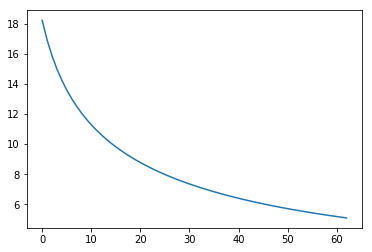

In [111]:
plt.plot(train_loss)